### Setup

In [1]:
%pip install netCDF4 h5netcdf xarray pandas "numpy<2" matplotlib seaborn packaging scipy store statsmodels plotly nbformat pmdarima


You should consider upgrading via the '/usr/local/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [143]:
data = pd.read_csv("mp_conc_weekly_full.csv")
data = data.set_index('time').dropna()
data.index = pd.to_datetime(data.index)
data

,mp_concentration
time,
2018-08-19,14.865665
2018-08-26,14.803406
2018-09-02,14.709439
2018-09-09,14.761217
2018-09-16,14.808359
...,...
2025-05-11,14.521454
2025-05-18,14.560788
2025-05-25,14.642275


### Boxcox Transform

In [131]:
from scipy.stats import boxcox
data['mp_conc_boxcox'], lam = boxcox(data['mp_concentration'])
data

,mp_concentration,mp_conc_boxcox
time,,
2018-08-19,14.865665,0.124086
2018-08-26,14.803406,0.124086
2018-09-02,14.709439,0.124086
2018-09-09,14.761217,0.124086
2018-09-16,14.808359,0.124086
...,...,...
2025-05-11,14.521454,0.124086
2025-05-18,14.560788,0.124086
2025-05-25,14.642275,0.124086


In [23]:
import plotly.express as px
import pandas as pd

def plot_data(df: pd.DataFrame,
                           y: str) -> None:
    """General function to plot the passenger data."""

    fig = px.line(df, x=df.index, y=y, labels={'Month': 'Date'})
    fig.update_layout(template="simple_white", title_text='mp_conc_boxcox',
                      width=650, height=400)

    return fig.show()

plot_data(df=data, y='mp_conc_boxcox')


In [7]:
import plotly.graph_objects as go
import nbformat

def plot_forecasts(forecasts_1: list[float], forecasts_2: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['mp_concentration'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['mp_concentration'], name='Test'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts_1, name='Forecast 1'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts_2, name='Forecast 2'))
    fig.update_layout(template="simple_white", font=dict(size=10), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Average Microplastic Concentration')

    return fig.show()


### ARIMA

In [5]:
from statsmodels.tsa.arima.model import ARIMA

train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]
train, test

(            mp_concentration  mp_conc_boxcox
 time                                        
 2018-08-19         14.865665        0.124086
 2018-08-26         14.803406        0.124086
 2018-09-02         14.709439        0.124086
 2018-09-09         14.761217        0.124086
 2018-09-16         14.808359        0.124086
 ...                      ...             ...
 2023-12-31         14.408309        0.124086
 2024-01-07         14.506263        0.124086
 2024-01-14         14.632690        0.124086
 2024-01-21         14.675417        0.124086
 2024-01-28         14.609019        0.124086
 
 [285 rows x 2 columns],
             mp_concentration  mp_conc_boxcox
 time                                        
 2024-02-04         14.550875        0.124086
 2024-02-11         14.532674        0.124086
 2024-02-18         14.548169        0.124086
 2024-02-25         14.541131        0.124086
 2024-03-03         14.602452        0.124086
 ...                      ...             ...
 2025-0

In [ ]:
from scipy.special import inv_boxcox
# Plot the forecasts
arima_1 = ARIMA(train.mp_conc_boxcox, order=(12,1,14)).fit()
boxcox_forecasts_1 = arima_1.forecast(len(test))
arima_forecasts_1 = inv_boxcox(boxcox_forecasts_1, lam)

arima_2 = ARIMA(train.mp_conc_boxcox, order=(1,1,12)).fit()
boxcox_forecasts_2 = arima_2.forecast(len(test))
arima_forecasts_2 = inv_boxcox(boxcox_forecasts_2, lam)
plot_forecasts(arima_forecasts_1, arima_forecasts_2, 'mp_concentration ARIMA')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978

### SARIMA

In [29]:
sarima_1 = ARIMA(train.mp_conc_boxcox, order=(10,1,10), seasonal_order=(1,1,1,12)).fit()
boxcox_forecasts_1 = sarima_1.forecast(len(test))
sarima_forecasts_1 = inv_boxcox(boxcox_forecasts_1, lam)

sarima_2 = ARIMA(train.mp_conc_boxcox, order=(10,1,9), seasonal_order=(1,1,1,12)).fit()
boxcox_forecasts_2 = sarima_2.forecast(len(test))
sarima_forecasts_2 = inv_boxcox(boxcox_forecasts_2, lam)
plot_forecasts(sarima_forecasts_1, sarima_forecasts_2, 'mp_concentration SARIMA')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency in

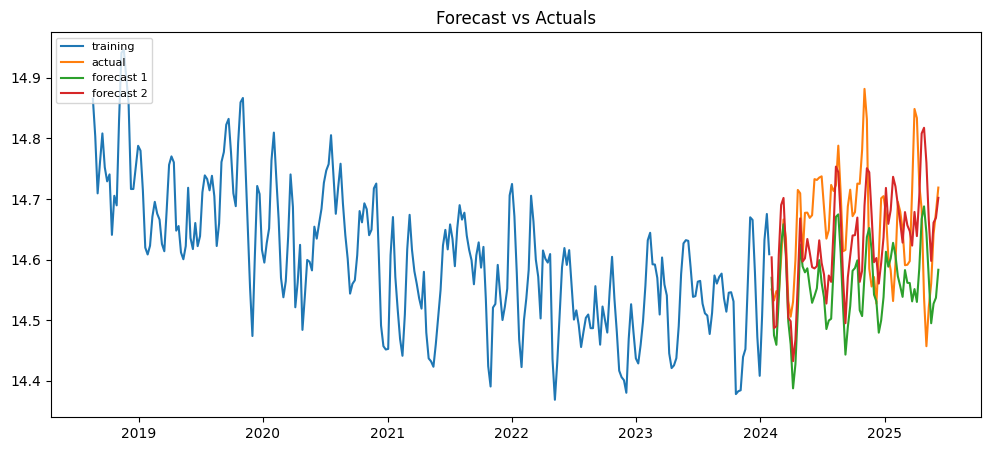

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.index, train.mp_concentration, label='training')
plt.plot(test.index, test.mp_concentration, label='actual')
plt.plot(test.index, sarima_forecasts_1, label='forecast 1')
plt.plot(test.index, sarima_forecasts_2, label='forecast 2')
#plt.fill_between(test.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [156]:
sarima_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                      mp_conc_boxcox   No. Observations:                  285
Model:             ARIMA(10, 1, 9)x(1, 1, [1], 12)   Log Likelihood                2746.261
Date:                             Mon, 21 Jul 2025   AIC                          -5448.522
Time:                                     13:42:56   BIC                          -5369.194
Sample:                                 08-19-2018   HQIC                         -5416.674
                                      - 01-28-2024                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0499   8.91e-20    5.6e+17      0.000       0.050       0.050
ar.L2         -0.2051   2.06e-19  -9.96e+17      0.000      -0.205      -0.205
ar.L3          0.4047   2.54e-20   1.59e+19      0.000       0.405       0.405
ar.L4         -0.4549   7.92e-21  -5.74e+19      0.000      -0.455      -0.455
ar.L5         -0.1717   1.48e-19  -1.16e+18      0.000      -0.172      -0.172
ar.L6         -0.0790   2.42e-20  -3.27e+18      0.000      -0.079      -0.079
ar.L7          0.3496   2.82e-19   1.24e+18      0.000       0.350       0.350
ar.L8          0.2853    1.9e-19    1.5e+18      0.000       0.285       0.285
ar.L9         -0.3595   2.32e-19  -1.55e+18      0.000      -0.360      -0.360
ar.L10        -0.2129   1.14e-19  -1.87e+18      0.000      -0.213      -0.213
ma.L1          0.1017   5.61e-20   1.81e+18      0.000       0.102       0.102
ma.L2         -0.0768   1.19e-19  -6.43e+17      0.000      -0.077      -0.077
ma.L3         -0.5161   3.19e-21  -1.62e+20      0.000      -0.516      -0.516
ma.L4          0.1770   4.67e-20   3.79e+18      0.000       0.177       0.177
ma.L5          0.0234   7.53e-20   3.11e+17      0.000       0.023       0.023
ma.L6          0.1005   2.04e-20   4.92e+18      0.000       0.100       0.100
ma.L7         -0.2555    4.7e-20  -5.44e+18      0.000      -0.255      -0.255
ma.L8         -0.2979   3.88e-20  -7.67e+18      0.000      -0.298      -0.298
ma.L9          0.1428   9.59e-20   1.49e+18      0.000       0.143       0.143
ar.S.L12      -0.3758   1.26e-19  -2.99e+18      0.000      -0.376      -0.376
ma.S.L12      -0.3031   1.12e-19   -2.7e+18      0.000      -0.303      -0.303
sigma2      9.868e-11   1.22e-10      0.808      0.419   -1.41e-10    3.38e-10
===================================================================================
Ljung-Box (L1) (Q):                   4.53   Jarque-Bera (JB):                 3.65
Prob(Q):                              0.03   Prob(JB):                         0.16
Heteroskedasticity (H):               1.02   Skew:                            -0.28
Prob(H) (two-sided):                  0.92   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.4e+37. Standard errors may be unstable.
"""

## Optuna

In [209]:
data = pd.read_csv("mp_conc_weekly_full.csv")
data = data.set_index('time').dropna()
data.index = pd.to_datetime(data.index)
data

,mp_concentration
time,
2018-08-19,14.865665
2018-08-26,14.803406
2018-09-02,14.709439
2018-09-09,14.761217
2018-09-16,14.808359
...,...
2025-05-11,14.521454
2025-05-18,14.560788
2025-05-25,14.642275


In [210]:
data['mp_conc_boxcox'], lam = boxcox(data['mp_concentration'])
data

,mp_concentration,mp_conc_boxcox
time,,
2018-08-19,14.865665,0.124086
2018-08-26,14.803406,0.124086
2018-09-02,14.709439,0.124086
2018-09-09,14.761217,0.124086
2018-09-16,14.808359,0.124086
...,...,...
2025-05-11,14.521454,0.124086
2025-05-18,14.560788,0.124086
2025-05-25,14.642275,0.124086


In [211]:
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]
train, test

(            mp_concentration  mp_conc_boxcox
 time                                        
 2018-08-19         14.865665        0.124086
 2018-08-26         14.803406        0.124086
 2018-09-02         14.709439        0.124086
 2018-09-09         14.761217        0.124086
 2018-09-16         14.808359        0.124086
 ...                      ...             ...
 2023-12-31         14.408309        0.124086
 2024-01-07         14.506263        0.124086
 2024-01-14         14.632690        0.124086
 2024-01-21         14.675417        0.124086
 2024-01-28         14.609019        0.124086
 
 [285 rows x 2 columns],
             mp_concentration  mp_conc_boxcox
 time                                        
 2024-02-04         14.550875        0.124086
 2024-02-11         14.532674        0.124086
 2024-02-18         14.548169        0.124086
 2024-02-25         14.541131        0.124086
 2024-03-03         14.602452        0.124086
 ...                      ...             ...
 2025-0

In [273]:
def objective(trial):
    try: 
        p = trial.suggest_int('p', 0, 11)
        d = trial.suggest_int('d', 1, 1) # Keeping d constrained as per your analysis
        q = trial.suggest_int('q', 0, 11)
        P = trial.suggest_int('P', 1, 1)
        D = trial.suggest_int('D', 1, 1) # Keeping D constrained
        Q = trial.suggest_int('Q', 1, 1)

        m = 12

        model =  ARIMA(train.mp_conc_boxcox, 
                        order=(p,d,q),
                        seasonal_order=(P,D,Q,m),
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit()

        return model.aicc
    except Exception:
        return np.inf

In [274]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2025-07-21 15:25:15,988] A new study created in memory with name: no-name-ac1f8ae7-6081-4bbd-9497-cdfe15ddb14a
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

[I 2025-07-21 15:25:17,376] Trial 0

In [275]:
best_params = study.best_params
print(best_params)

{'p': 5, 'd': 1, 'q': 6, 'P': 1, 'D': 1, 'Q': 1}


In [ ]:
# You can now use these best parameters to fit your final model

best_model = ARIMA(train.mp_conc_boxcox,
    order=(best_params['p'], best_params['d'], best_params['q']),
    seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], 12),
).fit()

print(best_model.summary())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



                                     SARIMAX Results                                      
Dep. Variable:                     mp_conc_boxcox   No. Observations:                  285
Model:             ARIMA(5, 1, 6)x(1, 1, [1], 12)   Log Likelihood                3482.056
Date:                            Mon, 21 Jul 2025   AIC                          -6936.112
Time:                                    15:31:00   BIC                          -6885.631
Sample:                                08-19-2018   HQIC                         -6915.845
                                     - 01-28-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2708   1.82e-18   1.49e+17      0.000       0.271       0.271
ar.L2         -0.5444   7.54e-19  -

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [280]:
boxcox_forecasts = best_model.forecast(len(test))

# Step 5: Apply the inverse Box-Cox transformation
sarima_forecasts = inv_boxcox(boxcox_forecasts, lam)

In [281]:
sarima_forecasts

2024-02-04    6.810341
2024-02-11         NaN
2024-02-18         NaN
2024-02-25    6.771126
2024-03-03         NaN
                ...   
2025-05-11    6.454426
2025-05-18         NaN
2025-05-25         NaN
2025-06-01    6.812387
2025-06-08         NaN
Freq: W-SUN, Name: predicted_mean, Length: 71, dtype: float64

In [282]:
import matplotlib.pyplot as plt
optuna.visualization.plot_optimization_history(study)

In [284]:
optuna.visualization.plot_parallel_coordinate(study)


In [285]:
optuna.visualization.plot_slice(study,params=['p','d','q'])

In [286]:
optuna.visualization.plot_param_importances(study)

## Pipeline Testing

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: Future

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-5594.674, Time=0.43 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-5598.674, Time=0.18 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-5537.004, Time=2.18 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-5119.546, Time=1.62 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-5506.873, Time=0.03 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=-5539.004, Time=0.64 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-5116.430, Time=1.00 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=-5601.083, Time=1.40 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=-5737.536, Time=0.76 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-836.200, Time=0.59 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=-5734.272, Time=1.72 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=9.69 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning:

invalid value encountered in reciprocal

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=-5735.536, Time=1.11 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning:

invalid value encountered in reciprocal

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=-5735.536, Time=0.99 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning:

invalid value encountered in reciprocal

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning:

invalid value encountered in reciprocal

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=-5733.536, Time=1.47 sec
 ARIMA(0,0,0)(2,1,1)[12]             : AIC=-5538.152, Time=0.31 sec

Best model:  ARIMA(0,0,0)(2,1,1)[12] intercept
Total fit time: 24.132 seconds

Final Model RMSE: 0.2986


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: Future

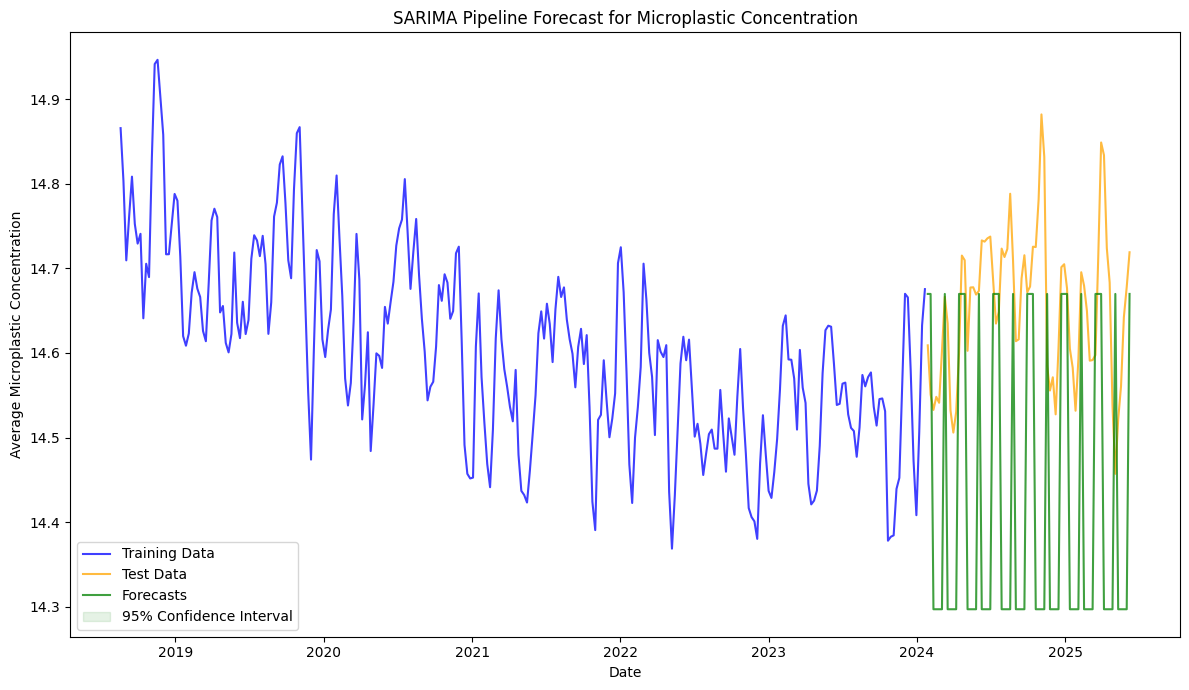

In [121]:
pipeline = Pipeline([
    ("boxcox", BoxCoxEndogTransformer()),
    ("model", pm.AutoARIMA( 
        suppress_warnings=True, 
        m=12,
        start_p=1, start_q=1, 
        max_p=5, max_q=5, 
        start_P=0, start_Q=0,
        max_P=2, max_Q=2,
        d=0, # SET d=0 HERE
        D=1, 
        trace=True,
        stepwise=True))
])

pipeline.fit(train)

preds_original, conf_int_original = pipeline.predict(
    n_periods=test.shape[0],
    return_conf_int=True
)

rmse = np.sqrt(mean_squared_error(test, preds_original))
print(f"\nFinal Model RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 7))
plt.plot(train, label='Training Data', color='blue', alpha=0.75)
plt.plot(test, label='Test Data', color='orange', alpha=0.75)
plt.plot(test.index, preds_original, label='Forecasts', color='green', alpha=0.75)
plt.fill_between(test.index, conf_int_original[:, 0], conf_int_original[:, 1],
                 alpha=0.1, color='green', label='95% Confidence Interval')

plt.title("SARIMA Pipeline Forecast for Microplastic Concentration")
plt.xlabel("Date")
plt.ylabel("Average Microplastic Concentration")
plt.legend()
plt.tight_layout()
plt.show()

In [106]:
preds_original

array([2.07216957, 2.07216936, 2.07216936, 2.07216936, 2.07196884,
       2.07196884, 2.07196884, 2.07196884, 2.07196884, 2.07196884,
       2.07196884, 2.07196884, 2.04022528, 2.04022524, 2.04022524,
       2.04022524, 2.04006409, 2.04006409, 2.04006409, 2.04006409,
       2.04006409, 2.04006409, 2.04006409, 2.04006409, 2.01406323,
       2.01406319, 2.01406319, 2.01406319, 2.01392881, 2.01392881,
       2.01392881, 2.01392881, 2.01392881, 2.01392881, 2.01392881,
       2.01392881, 1.99195228, 1.99195225, 1.99195225, 1.99195225,
       1.9918372 , 1.9918372 , 1.9918372 , 1.9918372 , 1.9918372 ,
       1.9918372 , 1.9918372 , 1.9918372 , 1.97283328, 1.97283326,
       1.97283326, 1.97283326, 1.97273281, 1.97273281, 1.97273281,
       1.97273281, 1.97273281, 1.97273281, 1.97273281, 1.97273281,
       1.95601182, 1.9560118 , 1.9560118 , 1.9560118 , 1.95592276,
       1.95592276, 1.95592276, 1.95592276, 1.95592276, 1.95592276,
       1.95592276, 1.95592276])

## Metrics

In [ ]:
# ##############################################################################
# 1. Load the data and split it into separate pieces

data = pd.read_csv('mp_conc_weekly_full.csv')
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)
data.dropna(subset=['mp_concentration'], inplace=True)
ts = data['mp_concentration']

# --- Perform Box-Cox Transformation ---
ts_transformed, lambda_value = boxcox(ts)
ts_transformed = pd.Series(ts_transformed, index=ts.index)

# Split the transformed data chronologically
train, test = model_selection.train_test_split(ts_transformed, train_size=0.8) # 80/20 split

# Keep the original test data for final evaluation
original_test = ts.loc[test.index]

# ##############################################################################
# 2. Fit a SARIMA model using auto_arima with the correct parameters for your data

print("Fitting SARIMA model on transformed data...")
modl = pm.auto_arima(train,
                     start_p=0, start_q=0,
                     max_p=3, max_q=3,
                     m=12,
                     start_P=0, start_Q=0,
                     max_P=2, max_Q=2,
                     seasonal=True,
                     stepwise=True, suppress_warnings=True,
                     d=None, D=1, # Enforce D=1, let auto_arima find d
                     error_action='ignore',
                     information_criterion='aicc',
                     trace=True)

print("\nBest Model Found:")
print(modl.summary())

# ##############################################################################
# 3. Create predictions for the future and evaluate on the original scale

preds_transformed, conf_int_transformed = modl.predict(n_periods=test.shape[0], return_conf_int=True)

# Perform the correct two-step inversion
# Step 1: Inverse Box-Cox
preds_original = inv_boxcox(preds_transformed, lambda_value)
conf_int_lower = inv_boxcox(conf_int_transformed[:, 0], lambda_value)
conf_int_upper = inv_boxcox(conf_int_transformed[:, 1], lambda_value)


# Print the error on the original scale
print("\nTest RMSE on Original Scale: %.3f" % np.sqrt(mean_squared_error(original_test, preds_original)))


# ##############################################################################
# 4. Plot the points and the forecasts

# Get the indices for plotting
x_train = train.index
x_test = test.index

plt.figure(figsize=(12, 7))

# Plot the training data and original test data
plt.plot(x_train, inv_boxcox(train, lambda_value), label='Training Data', color='blue', alpha=0.75)
plt.plot(x_test, original_test, label='Test Data', color='orange', alpha=0.75)

# Plot the forecasts
plt.plot(x_test, preds_original, label='Forecasts', color='green', alpha=0.75)

# Plot the confidence intervals
plt.fill_between(x_test, conf_int_lower, conf_int_upper,
                 alpha=0.1, color='green', label='95% Confidence Interval')

plt.title("SARIMA Forecast for Microplastic Concentration")
plt.xlabel("Date")
plt.ylabel("Average Microplastic Concentration")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def calculate_mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Remove zeros from y_true to avoid division by zero
    mask = y_true != 0
    if not np.any(mask):
        return np.inf
    
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    
    # Calculate MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

def calculate_smape(y_true, y_pred):
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate SMAPE
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    # Handle division by zero
    mask = denominator != 0
    if not np.any(mask):
        return np.inf
    
    smape = np.mean(numerator[mask] / denominator[mask]) * 100
    return smape

def calculate_msle(y_true, y_pred):
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Ensure all values are positive
    if np.any(y_true <= 0) or np.any(y_pred <= 0):
        raise ValueError("MSLE requires all values to be positive")
    
    # Calculate MSLE
    msle = np.mean((np.log1p(y_true) - np.log1p(y_pred)) ** 2)
    return msle

In [18]:
y_true = test['mp_concentration']
y_pred = arima_forecasts_1
    
print("ARIMA Forecast 1 Metrics:")
print("=" * 50)
    
print(f"MAE: {calculate_mae(y_true, y_pred):.4f}")
print(f"MSE: {calculate_mse(y_true, y_pred):.4f}")
print(f"RMSE: {calculate_rmse(y_true, y_pred):.4f}")
print(f"MAPE: {calculate_mape(y_true, y_pred):.4f}%")
print(f"SMAPE: {calculate_smape(y_true, y_pred):.4f}%")
print(f"MSLE: {calculate_msle(y_true, y_pred):.4f}")

y_true = test['mp_concentration']
y_pred = arima_forecasts_2
    
print()
print("ARIMA Forecast 2 Metrics:")
print("=" * 50)
    
print(f"MAE: {calculate_mae(y_true, y_pred):.4f}")
print(f"MSE: {calculate_mse(y_true, y_pred):.4f}")
print(f"RMSE: {calculate_rmse(y_true, y_pred):.4f}")
print(f"MAPE: {calculate_mape(y_true, y_pred):.4f}%")
print(f"SMAPE: {calculate_smape(y_true, y_pred):.4f}%")
print(f"MSLE: {calculate_msle(y_true, y_pred):.4f}")

ARIMA Forecast 1 Metrics:
MAE: 0.0808
MSE: 0.0097
RMSE: 0.0986
MAPE: 0.5498%
SMAPE: 0.5514%
MSLE: 0.0000

ARIMA Forecast 2 Metrics:
MAE: 0.0808
MSE: 0.0097
RMSE: 0.0986
MAPE: 0.5498%
SMAPE: 0.5514%
MSLE: 0.0000
